#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

from scipy.stats import ttest_ind

import pandas as pd
import holoviews as hv
from holoviews import opts

from tqdm import tqdm
import os

import networkx as nx
import matplotlib.colors as mcolors

In [2]:
import torch
from torch import nn

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#### Test for CUDA

In [4]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
    device = torch.device('cpu')
else:
    print('GPU found, training on GPU')
    device = torch.device('cuda')

GPU found, training on GPU


#### Initialize paths

In [5]:
nRuns = 5

In [6]:
latent_scaling = 16
pop_list_types = [12,2,1]

In [7]:
n_areas = 2
n_depths = 3

## Number of recurrent neurons in total
N = int(n_areas*n_depths*np.sum(pop_list_types)*latent_scaling)

In [8]:
## Population
label_arr_pop = ['V1_L4_pyr','V1_L4_sst','V1_L4_vip',
             'V1_L23_pyr','V1_L23_sst','V1_L23_vip',
             'V1_L5_pyr','V1_L5_sst','V1_L5_vip',
             'LM_L4_pyr','LM_L4_sst','LM_L4_vip',
             'LM_L23_pyr','LM_L23_sst','LM_L23_vip',
             'LM_L5_pyr','LM_L5_sst','LM_L5_vip']

## Layers
label_arr_layers = ['V1_L4', 'V1_L23', 'V1_L5', 'LM_L4', 'LM_L23', 'LM_L5']
## Areas
label_arr_areas = ['V1','LM']

n_cell_types = len(label_arr_pop)

In [9]:
start_V1_L4_Pyr = 0
end_V1_L4_Pyr = start_V1_L4_Pyr + pop_list_types[0]*latent_scaling

start_V1_L4_SST = end_V1_L4_Pyr
end_V1_L4_SST = start_V1_L4_SST + pop_list_types[1]*latent_scaling

start_V1_L4_VIP = end_V1_L4_SST
end_V1_L4_VIP = start_V1_L4_VIP + pop_list_types[2]*latent_scaling

## V1, L2/3
start_V1_L23_Pyr = end_V1_L4_VIP
end_V1_L23_Pyr = start_V1_L23_Pyr + pop_list_types[0]*latent_scaling

start_V1_L23_SST = end_V1_L23_Pyr
end_V1_L23_SST = start_V1_L23_SST + pop_list_types[1]*latent_scaling

start_V1_L23_VIP = end_V1_L23_SST
end_V1_L23_VIP = start_V1_L23_VIP + pop_list_types[2]*latent_scaling

## V1, L5
start_V1_L5_Pyr = end_V1_L23_VIP
end_V1_L5_Pyr = start_V1_L5_Pyr + pop_list_types[0]*latent_scaling

start_V1_L5_SST = end_V1_L5_Pyr
end_V1_L5_SST = start_V1_L5_SST + pop_list_types[1]*latent_scaling

start_V1_L5_VIP = end_V1_L5_SST
end_V1_L5_VIP = start_V1_L5_VIP + pop_list_types[2]*latent_scaling

## LM, L4
start_LM_L4_Pyr = end_V1_L5_VIP ## would need to be changed if using L6 populations as well
end_LM_L4_Pyr = start_LM_L4_Pyr + pop_list_types[0]*latent_scaling

start_LM_L4_SST = end_LM_L4_Pyr
end_LM_L4_SST = start_LM_L4_SST + pop_list_types[1]*latent_scaling

start_LM_L4_VIP = end_LM_L4_SST
end_LM_L4_VIP = start_LM_L4_VIP + pop_list_types[2]*latent_scaling

## LM, L2/3
start_LM_L23_Pyr = end_LM_L4_VIP
end_LM_L23_Pyr = start_LM_L23_Pyr + pop_list_types[0]*latent_scaling

start_LM_L23_SST = end_LM_L23_Pyr
end_LM_L23_SST = start_LM_L23_SST + pop_list_types[1]*latent_scaling

start_LM_L23_VIP = end_LM_L23_SST
end_LM_L23_VIP = start_LM_L23_VIP + pop_list_types[2]*latent_scaling

## LM, L5
start_LM_L5_Pyr = end_LM_L23_VIP
end_LM_L5_Pyr = start_LM_L5_Pyr + pop_list_types[0]*latent_scaling

start_LM_L5_SST = end_LM_L5_Pyr
end_LM_L5_SST = start_LM_L5_SST + pop_list_types[1]*latent_scaling

start_LM_L5_VIP = end_LM_L5_SST
end_LM_L5_VIP = start_LM_L5_VIP + pop_list_types[2]*latent_scaling

In [10]:
## Population
block_indices_pop = [(start_V1_L4_Pyr,end_V1_L4_Pyr), (start_V1_L4_SST,end_V1_L4_SST), (start_V1_L4_VIP,end_V1_L4_VIP),
                 (start_V1_L23_Pyr,end_V1_L23_Pyr), (start_V1_L23_SST,end_V1_L23_SST), (start_V1_L23_VIP,end_V1_L23_VIP),
                 (start_V1_L5_Pyr,end_V1_L5_Pyr), (start_V1_L5_SST,end_V1_L5_SST), (start_V1_L5_VIP,end_V1_L5_VIP),
                 (start_LM_L4_Pyr,end_LM_L4_Pyr), (start_LM_L4_SST,end_LM_L4_SST), (start_LM_L4_VIP,end_LM_L4_VIP),
                 (start_LM_L23_Pyr,end_LM_L23_Pyr), (start_LM_L23_SST,end_LM_L23_SST), (start_LM_L23_VIP,end_LM_L23_VIP),
                 (start_LM_L5_Pyr,end_LM_L5_Pyr), (start_LM_L5_SST,end_LM_L5_SST), (start_LM_L5_VIP,end_LM_L5_VIP)]

## Layers
block_indices_layers = [(start_V1_L4_Pyr,end_V1_L4_VIP), (start_V1_L23_Pyr,end_V1_L23_VIP), (start_V1_L5_Pyr,end_V1_L5_VIP),
                        (start_LM_L4_Pyr,end_LM_L4_VIP), (start_LM_L23_Pyr,end_LM_L23_VIP), (start_LM_L5_Pyr,end_LM_L5_VIP)]

## Areas
block_indices_areas = [(start_V1_L4_Pyr,end_V1_L5_VIP), (start_LM_L4_Pyr,end_LM_L5_VIP)]

#### Architecture

In [11]:
# Define the neural network
class CelltypeRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, device):

        super(CelltypeRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True, nonlinearity='tanh', bias=False)

        self.fc1 = nn.Linear(round(pop_list_types[0]*latent_scaling), num_classes)
        self.fc2 = nn.Linear(round(pop_list_types[1]*latent_scaling), num_classes)
        self.fc3 = nn.Linear(round(pop_list_types[2]*latent_scaling), num_classes)
        self.fc4 = nn.Linear(round(pop_list_types[0]*latent_scaling), num_classes)
        self.fc5 = nn.Linear(round(pop_list_types[1]*latent_scaling), num_classes)
        self.fc6 = nn.Linear(round(pop_list_types[2]*latent_scaling), num_classes)
        self.fc7 = nn.Linear(round(pop_list_types[0]*latent_scaling), num_classes)
        self.fc8 = nn.Linear(round(pop_list_types[1]*latent_scaling), num_classes)
        self.fc9 = nn.Linear(round(pop_list_types[2]*latent_scaling), num_classes)

        self.fc10 = nn.Linear(round(pop_list_types[0]*latent_scaling), num_classes)
        self.fc11 = nn.Linear(round(pop_list_types[1]*latent_scaling), num_classes)
        self.fc12 = nn.Linear(round(pop_list_types[2]*latent_scaling), num_classes)
        self.fc13 = nn.Linear(round(pop_list_types[0]*latent_scaling), num_classes)
        self.fc14 = nn.Linear(round(pop_list_types[1]*latent_scaling), num_classes)
        self.fc15 = nn.Linear(round(pop_list_types[2]*latent_scaling), num_classes)
        self.fc16 = nn.Linear(round(pop_list_types[0]*latent_scaling), num_classes)
        self.fc17 = nn.Linear(round(pop_list_types[1]*latent_scaling), num_classes)
        self.fc18 = nn.Linear(round(pop_list_types[2]*latent_scaling), num_classes)

        self.fc1.weight.requires_grad = False
        self.fc1.bias.requires_grad = False

        self.fc2.weight.requires_grad = False
        self.fc2.bias.requires_grad = False

        self.fc3.weight.requires_grad = False
        self.fc3.bias.requires_grad = False

        self.fc4.weight.requires_grad = False
        self.fc4.bias.requires_grad = False

        self.fc5.weight.requires_grad = False
        self.fc5.bias.requires_grad = False

        self.fc6.weight.requires_grad = False
        self.fc6.bias.requires_grad = False

        self.fc7.weight.requires_grad = False
        self.fc7.bias.requires_grad = False

        self.fc8.weight.requires_grad = False
        self.fc8.bias.requires_grad = False

        self.fc9.weight.requires_grad = False
        self.fc9.bias.requires_grad = False

        self.fc10.weight.requires_grad = False
        self.fc10.bias.requires_grad = False

        self.fc11.weight.requires_grad = False
        self.fc11.bias.requires_grad = False

        self.fc12.weight.requires_grad = False
        self.fc12.bias.requires_grad = False

        self.fc13.weight.requires_grad = False
        self.fc13.bias.requires_grad = False

        self.fc14.weight.requires_grad = False
        self.fc14.bias.requires_grad = False

        self.fc15.weight.requires_grad = False
        self.fc15.bias.requires_grad = False

        self.fc16.weight.requires_grad = False
        self.fc16.bias.requires_grad = False

        self.fc17.weight.requires_grad = False
        self.fc17.bias.requires_grad = False

        self.fc18.weight.requires_grad = False
        self.fc18.bias.requires_grad = False

        self.n_classes = num_classes
        self.device = device

    def forward(self, x):
        ## Define input mask
        in_mask = torch.zeros(self.hidden_size, self.input_size).to(device)
        in_mask[start_V1_L4_Pyr:end_V1_L4_Pyr,0] = 1
        in_mask[start_V1_L4_SST:end_V1_L4_SST,1] = 1
        in_mask[start_V1_L4_VIP:end_V1_L4_VIP,2] = 1

        in_mask[start_V1_L23_Pyr:end_V1_L23_Pyr,3] = 1
        in_mask[start_V1_L23_SST:end_V1_L23_SST,4] = 1
        in_mask[start_V1_L23_VIP:end_V1_L23_VIP,5] = 1

        in_mask[start_V1_L5_Pyr:end_V1_L5_Pyr,6] = 1
        in_mask[start_V1_L5_SST:end_V1_L5_SST,7] = 1
        in_mask[start_V1_L5_VIP:end_V1_L5_VIP,8] = 1

        in_mask[start_LM_L4_Pyr:end_LM_L4_Pyr,9] = 1
        in_mask[start_LM_L4_SST:end_LM_L4_SST,10] = 1
        in_mask[start_LM_L4_VIP:end_LM_L4_VIP,11] = 1

        in_mask[start_LM_L23_Pyr:end_LM_L23_Pyr,12] = 1
        in_mask[start_LM_L23_SST:end_LM_L23_SST,13] = 1
        in_mask[start_LM_L23_VIP:end_LM_L23_VIP,14] = 1

        in_mask[start_LM_L5_Pyr:end_LM_L5_Pyr,15] = 1
        in_mask[start_LM_L5_SST:end_LM_L5_SST,16] = 1
        in_mask[start_LM_L5_VIP:end_LM_L5_VIP,17] = 1

        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        nSamp, inDim, nSteps = x.shape

        ops = torch.zeros(nSamp,nSteps,self.hidden_size, requires_grad=False).to(self.device)

        pred1 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred2 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred3 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred4 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred5 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred6 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred7 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred8 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred9 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)

        pred10 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred11 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred12 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred13 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred14 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred15 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred16 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred17 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred18 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)

        for ii in range(nSteps):
            ## Apply input mask
            self.rnn.weight_ih_l0.data.mul(in_mask)

            ip = torch.unsqueeze(x[:,:,ii],-1).view(nSamp,1,inDim)
            op, ht = self.rnn(ip,h0) ## pass 1 timestep through RNN
            fr_mask = ht.clone()>0
            htt = fr_mask*ht.clone() ## mask firing rate
            h0 = htt ## update hidden state
            ops[:,ii,:] = torch.squeeze(op.clone())

            ## Final prediction at every timestep
            pred1[:,ii,:] = self.fc1(ops[:, ii, start_V1_L4_Pyr:end_V1_L4_Pyr].clone())
            pred2[:,ii,:] = self.fc2(ops[:, ii, start_V1_L4_SST:end_V1_L4_SST].clone())
            pred3[:,ii,:] = self.fc3(ops[:, ii, start_V1_L4_VIP:end_V1_L4_VIP].clone())
            pred4[:,ii,:] = self.fc4(ops[:, ii, start_V1_L23_Pyr:end_V1_L23_Pyr].clone())
            pred5[:,ii,:] = self.fc5(ops[:, ii, start_V1_L23_SST:end_V1_L23_SST].clone())
            pred6[:,ii,:] = self.fc6(ops[:, ii, start_V1_L23_VIP:end_V1_L23_VIP].clone())
            pred7[:,ii,:] = self.fc7(ops[:, ii, start_V1_L5_Pyr:end_V1_L5_Pyr].clone())
            pred8[:,ii,:] = self.fc8(ops[:, ii, start_V1_L5_SST:end_V1_L5_SST].clone())
            pred9[:,ii,:] = self.fc9(ops[:, ii, start_V1_L5_VIP:end_V1_L5_VIP].clone())

            pred10[:,ii,:] = self.fc10(ops[:, ii, start_LM_L4_Pyr:end_LM_L4_Pyr].clone())
            pred11[:,ii,:] = self.fc11(ops[:, ii, start_LM_L4_SST:end_LM_L4_SST].clone())
            pred12[:,ii,:] = self.fc12(ops[:, ii, start_LM_L4_VIP:end_LM_L4_VIP].clone())
            pred13[:,ii,:] = self.fc13(ops[:, ii, start_LM_L23_Pyr:end_LM_L23_Pyr].clone())
            pred14[:,ii,:] = self.fc14(ops[:, ii, start_LM_L23_SST:end_LM_L23_SST].clone())
            pred15[:,ii,:] = self.fc15(ops[:, ii, start_LM_L23_VIP:end_LM_L23_VIP].clone())
            pred16[:,ii,:] = self.fc16(ops[:, ii, start_LM_L5_Pyr:end_LM_L5_Pyr].clone())
            pred17[:,ii,:] = self.fc17(ops[:, ii, start_LM_L5_SST:end_LM_L5_SST].clone())
            pred18[:,ii,:] = self.fc18(ops[:, ii, start_LM_L5_VIP:end_LM_L5_VIP].clone())

        out1 = pred1.clone() #Take the output from the last time step
        out2 = pred2.clone() #Take the output from the last time step
        out3 = pred3.clone() #Take the output from the last time step
        out4 = pred4.clone() #Take the output from the last time step
        out5 = pred5.clone() #Take the output from the last time step
        out6 = pred6.clone() #Take the output from the last time step
        out7 = pred7.clone() #Take the output from the last time step
        out8 = pred8.clone() #Take the output from the last time step
        out9 = pred9.clone() #Take the output from the last time step

        out10 = pred10.clone() #Take the output from the last time step
        out11 = pred11.clone() #Take the output from the last time step
        out12 = pred12.clone() #Take the output from the last time step
        out13 = pred13.clone() #Take the output from the last time step
        out14 = pred14.clone() #Take the output from the last time step
        out15 = pred15.clone() #Take the output from the last time step
        out16 = pred16.clone() #Take the output from the last time step
        out17 = pred17.clone() #Take the output from the last time step
        out18 = pred18.clone() #Take the output from the last time step

        return torch.dstack((out1,out2, out3, out4, out5, out6, out7, out8, out9,
                             out10,out11, out12, out13, out14, out15, out16, out17, out18)), htt

In [12]:
def average_weights_in_blocks_matrix(weight_matrix, block_indices, use_absolute_values=False):
    n_blocks = len(block_indices)
    averages_matrix = np.zeros((n_blocks, n_blocks))

    for i, (start_i, end_i) in enumerate(block_indices):
        for j, (start_j, end_j) in enumerate(block_indices):
            block_weights = weight_matrix[start_i:end_i, start_j:end_j]  # Extract the block of weights ##had +1 at end_js

            if use_absolute_values:
                block_weights = np.abs(block_weights)

            block_average = np.mean(block_weights)  # Calculate the average
            averages_matrix[i, j] = block_average

    return averages_matrix


def average_sparsity_in_blocks_matrix(weight_matrix, block_indices):
    n_blocks = len(block_indices)
    averages_matrix = np.zeros((n_blocks, n_blocks))

    for i, (start_i, end_i) in enumerate(block_indices):
        for j, (start_j, end_j) in enumerate(block_indices):
            block_prob = np.count_nonzero(abs(weight_matrix[start_i:end_i, start_j:end_j]) >= 1e-5)  # Extract the block of weights ##had +1 at end_js


            block_average = block_prob/weight_matrix[start_i:end_i, start_j:end_j].size  # Calculate the average
            averages_matrix[i, j] = block_average

    return averages_matrix

#### Load weights, also always model 2 - model1

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
suffix_dict = {
    'FC':'Familiar-Change-Sparse-Frozen/',
    'FN':'Familiar-No-Change-Sparse-Frozen/',
    'FO':'Familiar-Omission-Sparse-Frozen/',
    'NC':'Novel-Change-Sparse-Frozen/',
    'NN':'Novel-No-Change-Sparse-Frozen/',
    'NO':'Novel-Omission-Sparse-Frozen/',
}

In [15]:
suffix_pair_list = [['FN', 'FC'], ['FN', 'FO'], ['FC','FO'], ['NN','NC'], ['NN','NO'], ['NC','NO'], ['FN', 'NN'], ['FC', 'NC'], ['FO', 'NO']]

In [16]:
pp = '/content/drive/My Drive/Aish_celltypeRNN/Repeated-Runs-Dales-Pruning/SubRUN/'

In [17]:
store_path = '/content/drive/My Drive/Aish_celltypeRNN/celltype-comparisons/Shorter!/'

Familiar-No-Change-Sparse-Frozen/
Familiar-Change-Sparse-Frozen/


<ipython-input-19-7a77ec300c1d>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1[cntr].load_state_dict(torch.load(path1[cntr]))
<ipython-input-19-7a77ec300c1d>:24: F

Familiar-No-Change-Sparse-Frozen/
Familiar-Omission-Sparse-Frozen/
Familiar-Change-Sparse-Frozen/
Familiar-Omission-Sparse-Frozen/
Novel-No-Change-Sparse-Frozen/
Novel-Change-Sparse-Frozen/
Novel-No-Change-Sparse-Frozen/
Novel-Omission-Sparse-Frozen/
Novel-Change-Sparse-Frozen/
Novel-Omission-Sparse-Frozen/
Familiar-No-Change-Sparse-Frozen/
Novel-No-Change-Sparse-Frozen/


<ipython-input-19-7a77ec300c1d>:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Familiar-Change-Sparse-Frozen/
Novel-Change-Sparse-Frozen/
Familiar-Omission-Sparse-Frozen/
Novel-Omission-Sparse-Frozen/


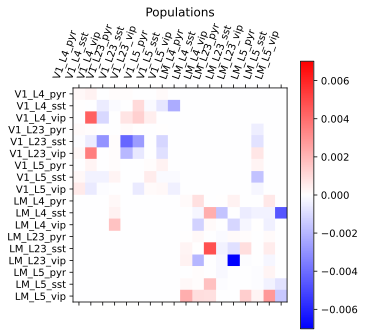

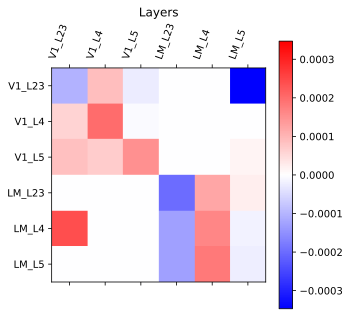

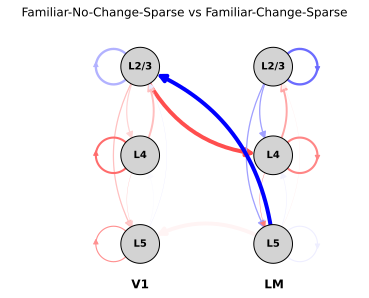

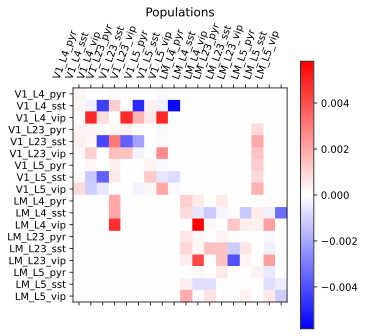

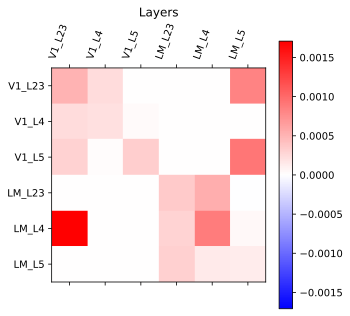

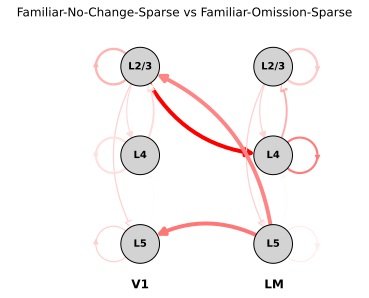

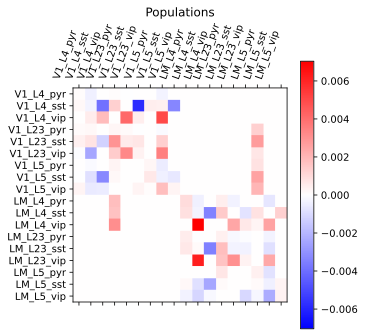

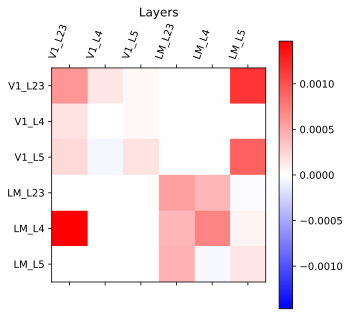

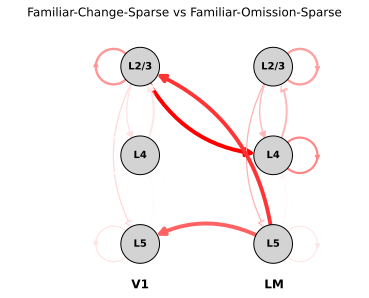

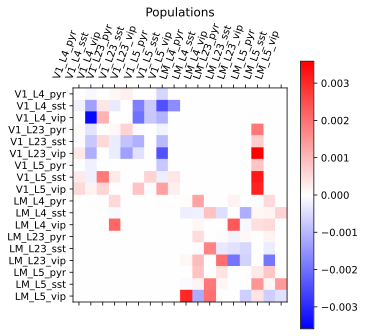

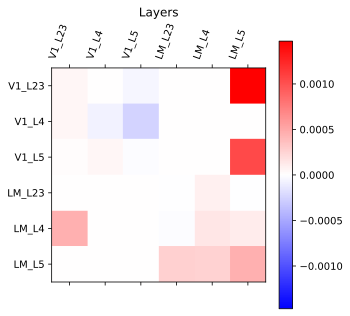

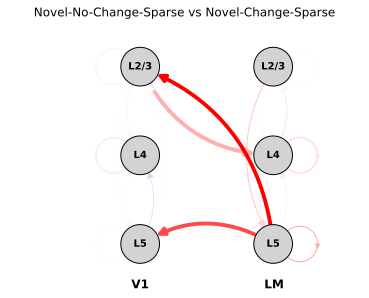

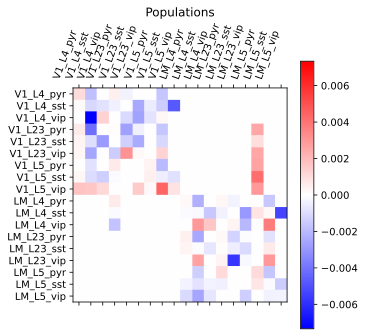

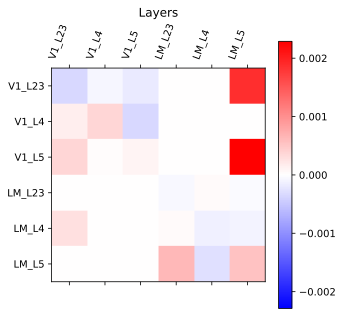

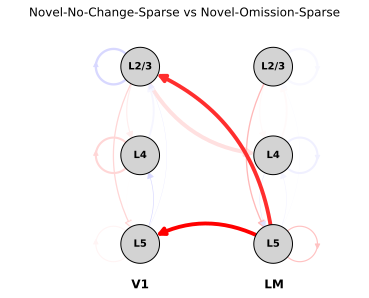

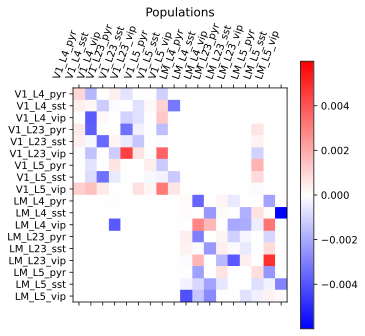

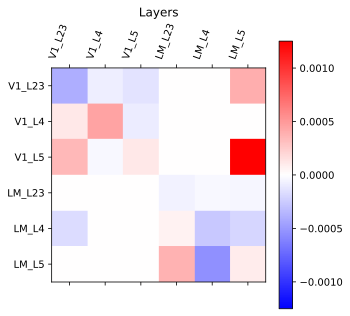

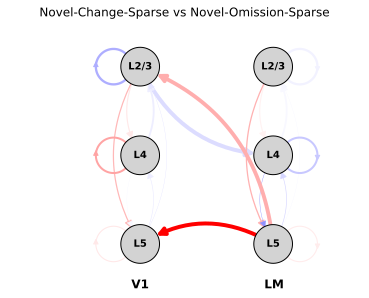

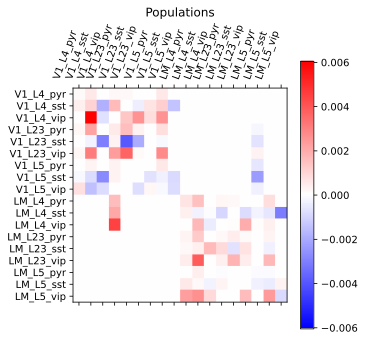

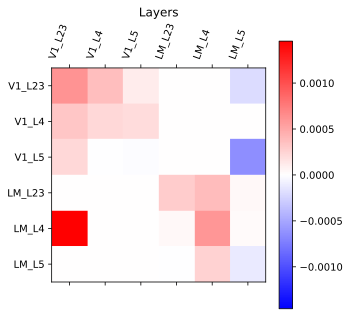

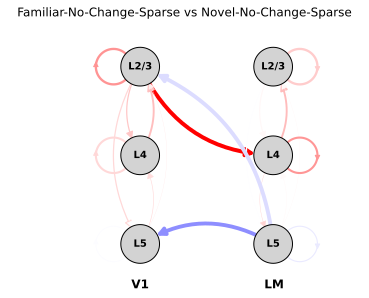

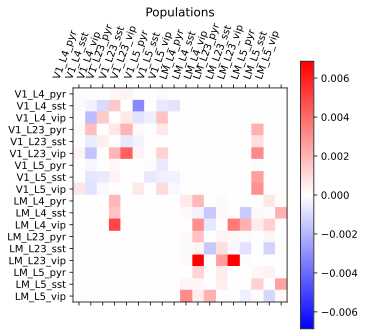

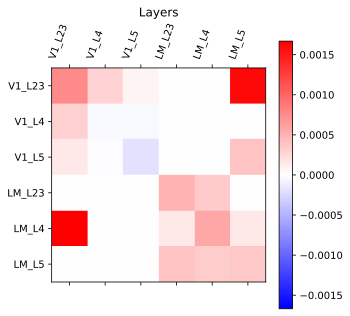

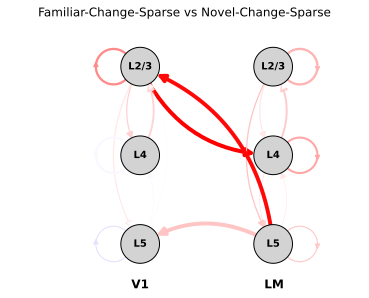

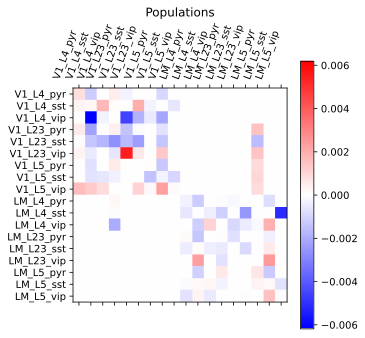

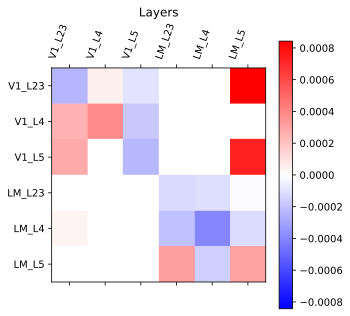

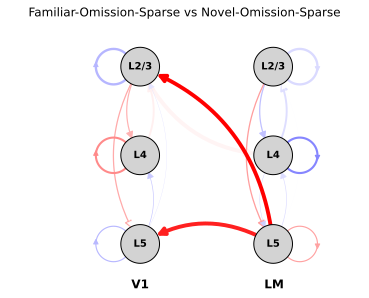

In [19]:
for suffix_pair in suffix_pair_list:
    suffix1 = suffix_dict[suffix_pair[0]]
    suffix2 = suffix_dict[suffix_pair[1]]
    print(suffix1)
    print(suffix2)

    # first load the trained RNNs
    npp = {}
    path1 = {}
    path2 = {}

    model1 = {}
    model2 = {}

    for cntr in range(nRuns):
        npp[cntr] = 'celltype-dale-pruning-latent-16-'+str(cntr)
        path1[cntr] = pp + suffix1 + npp[cntr]+'/pts-'+str(cntr)+'/celltypeRNN-dale-sparse-'+str(latent_scaling)+'.pt'
        path2[cntr] = pp + suffix2 + npp[cntr]+'/pts-'+str(cntr)+'/celltypeRNN-dale-sparse-'+str(latent_scaling)+'.pt'

        model1[cntr] = CelltypeRNN(18, N, 1, device)
        model2[cntr] = CelltypeRNN(18, N, 1, device)

        model1[cntr].load_state_dict(torch.load(path1[cntr]))
        model2[cntr].load_state_dict(torch.load(path2[cntr]))

    weights1 = {}
    weights2 = {}

    for cntr in range(nRuns):
        weights1[cntr] = model1[cntr].rnn._parameters['weight_hh_l0'].cpu().detach().numpy()
        weights2[cntr] = model2[cntr].rnn._parameters['weight_hh_l0'].cpu().detach().numpy()


    # then let's fucking get the average
    model1_pop = {}
    model2_pop = {}
    model1_layers = {}
    model2_layers = {}
    model1_areas = {}
    model2_areas = {}
    model1_layers_prob = {}
    model2_layers_prob = {}

    for cntr in range(nRuns):
        ## Populations
        model1_pop[cntr] = average_weights_in_blocks_matrix(weights1[cntr], block_indices_pop, use_absolute_values=True)
        model2_pop[cntr] = average_weights_in_blocks_matrix(weights2[cntr], block_indices_pop, use_absolute_values=True)

        ##Layers
        model1_layers[cntr] = average_weights_in_blocks_matrix(weights1[cntr], block_indices_layers, use_absolute_values=True)
        model2_layers[cntr] = average_weights_in_blocks_matrix(weights2[cntr], block_indices_layers, use_absolute_values=True)

        ##Areas
        model1_areas[cntr] = average_weights_in_blocks_matrix(weights1[cntr], block_indices_areas, use_absolute_values=True)
        model2_areas[cntr] = average_weights_in_blocks_matrix(weights2[cntr], block_indices_areas, use_absolute_values=True)

        model1_layers_prob[cntr] = average_sparsity_in_blocks_matrix(weights1[cntr], block_indices_layers)
        model2_layers_prob[cntr] = average_sparsity_in_blocks_matrix(weights2[cntr], block_indices_layers)

    model1_layers_prob_mean = 0
    model2_layers_prob_mean = 0
    for cntr in range(nRuns):
        model1_layers_prob_mean += model1_layers_prob[cntr]
        model2_layers_prob_mean += model2_layers_prob[cntr]

    model1_layers_prob_mean = model1_layers_prob_mean/nRuns
    model2_layers_prob_mean = model2_layers_prob_mean/nRuns

    model_layers_prob_mean = (model1_layers_prob_mean + model2_layers_prob_mean)/2

    # compute the difference
    diff_pop_all = np.zeros((nRuns*nRuns,model1_pop[0].shape[0],model1_pop[0].shape[1]))
    diff_layers_all = np.zeros((nRuns*nRuns,model1_layers[0].shape[0],model1_layers[0].shape[1]))
    diff_areas_all = np.zeros((nRuns*nRuns,model1_areas[0].shape[0],model1_areas[0].shape[1]))

    kk = 0
    for cntr1 in range(nRuns):
        for cntr2 in range(nRuns):
            diff_pop_all[kk] = model2_pop[cntr2] - model1_pop[cntr1]
            diff_layers_all[kk] = model2_layers[cntr2] - model1_layers[cntr1]
            diff_areas_all[kk] = model2_areas[cntr2] - model1_areas[cntr1]
            kk += 1

    diff_pop = np.mean(diff_pop_all,0)
    diff_layers = np.mean(diff_layers_all,0)
    diff_areas = np.mean(diff_areas_all,0)

    plt.matshow(np.random.rand(10,10), cmap='bwr', vmin=-1, vmax=1)
    #plt.colorbar()
    plt.savefig(store_path+'whatsupman.svg', format='svg')

    # plot the difference at the celltype level
    plt.imshow(diff_pop, cmap='bwr', vmin=-np.max(abs(diff_pop)), vmax=np.max(abs(diff_pop)))
    plt.title("Populations")
    plt.colorbar()
    plt.xticks(np.arange(len(label_arr_pop)), label_arr_pop, rotation=70, ha='right')
    plt.yticks(np.arange(len(label_arr_pop)), label_arr_pop)
    plt.savefig(store_path + suffix1[:-8] +' vs ' + suffix2[:-8] + '_celltype.svg', format='svg')

    # plot the difference at the layer level
    # let's swap the order for layers to make it L23, L4, L5
    diff_layers_re = diff_layers.copy()
    # Swap first and second rows/columns
    diff_layers_re[[0, 1]] = diff_layers_re[[1, 0]]  # Swap rows
    diff_layers_re[:, [0, 1]] = diff_layers_re[:, [1, 0]]  # Swap columns
    # Swap fourth and fifth rows/columns
    diff_layers_re[[3, 4]] = diff_layers_re[[4, 3]]  # Swap rows
    diff_layers_re[:, [3, 4]] = diff_layers_re[:, [4, 3]]  # Swap columns

    model_layers_prob_mean_re = model_layers_prob_mean.copy()
    model_layers_prob_mean_re[[0, 1]] = model_layers_prob_mean_re[[1, 0]]  # Swap rows
    model_layers_prob_mean_re[:, [0, 1]] = model_layers_prob_mean_re[:, [1, 0]] # Swap columns
    model_layers_prob_mean_re[[3, 4]] = model_layers_prob_mean_re[[4, 3]]  # Swap rows
    model_layers_prob_mean_re[:, [3, 4]] = model_layers_prob_mean_re[:, [4, 3]]


    # Reordering the labels in the same way
    label_arr_layers_re = label_arr_layers.copy()
    label_arr_layers_re[0], label_arr_layers_re[1] = label_arr_layers_re[1], label_arr_layers_re[0]  # Swap first and second
    label_arr_layers_re[3], label_arr_layers_re[4] = label_arr_layers_re[4], label_arr_layers_re[3]


    plt.matshow(diff_layers_re, cmap='bwr',  vmin=-np.max(abs(diff_layers_re)), vmax=np.max(abs(diff_layers_re)))
    plt.title("Layers")
    plt.colorbar()
    plt.xticks(np.arange(len(label_arr_layers_re)), label_arr_layers_re, rotation=70, ha='right')
    plt.yticks(np.arange(len(label_arr_layers_re)), label_arr_layers_re)

    plt.savefig(store_path + suffix1[:-8] +' vs ' + suffix2[:-8] + '.svg', format='svg')

    # for layers, we also plot the network structure additionally
    color_matrix = diff_layers_re.T
    width_matrix = model_layers_prob_mean_re.T
    w_scale = 4
    norm = mcolors.Normalize(vmin=-abs(color_matrix).max(), vmax=abs(color_matrix).max())
    #cmap = plt.cm.RdBu
    cmap = plt.cm.bwr

    G = nx.DiGraph()

    # Add nodes
    for i in range(0, 6):
        G.add_node(i)

    edge_colors = []

    # Add edges based on connection matrix
    for i in range(6):
        for j in range(6):
            prob = width_matrix[i, j] # thickness by prob
            #weight = color_matrix[i, j] # color by value
            if prob != 0 and i!=j:  # only add edges with non-zero weights
                G.add_edge(i, j, weight=prob)
                edge_colors.append(cmap(norm(color_matrix[i, j])))

    # Manually set the positions of the nodes
    pos = {
        0: (0, 1),  # Node 1 at (0,1)
        1: (0, 0),  # Node 2 at (0,0)
        2: (0, -1), # Node 3 at (0,-1)
        3: (1.5, 1),  # Node 4 at (1,1)
        4: (1.5, 0),  # Node 5 at (1,0)
        5: (1.5, -1)  # Node 6 at (1,-1)
    }

    custom_labels = {0: 'L2/3', 1: 'L4', 2: 'L5', 3: 'L2/3', 4: 'L4', 5: 'L5'}

    fig, ax = plt.subplots()
    ax.set_xlim(-1.5, 2.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')  # Set the aspect ratio to be equal

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=1500, edgecolors='black', label=None)

    # Draw non-self-loop edges
    non_self_loops = [(u, v) for u, v in G.edges() if u != v]
    edge_widths_nonself = [G[u][v]['weight']*w_scale/np.max(abs(width_matrix)) for u, v in non_self_loops] # Scale weight for visualization

    nx.draw_networkx_edges(G, pos, edgelist=non_self_loops, width=edge_widths_nonself,edge_color=edge_colors,
                          arrows=True, arrowstyle='-|>', connectionstyle='arc3,rad=0.3',
                          arrowsize=[ 15 for x in edge_widths_nonself], min_target_margin=18)


    # now let's add self loops
    for ii in range(6):
        prob = width_matrix[ii, ii] # thickness by prob
        #weight = color_matrix[i, j] # color by value
        if prob != 0 :  # only add edges with non-zero weights
            G.add_edge(ii, ii, weight=prob)

    self_loops = [(u, v) for u, v in G.edges() if u == v]
    edge_widths_loop = [G[u][v]['weight']*w_scale/np.max(abs(width_matrix)) for u, v in self_loops]

    for u, v in self_loops:
        connect_prob = G[u][v]['weight']*w_scale/np.max(abs(width_matrix))
        color_loop = cmap(norm(color_matrix[u, v]))

        if color_matrix[u, v] >= 0:
            if u <= 2:
                loop = plt.Circle((pos[u][0]-0.3, pos[u][1]), 0.2, color=color_loop, fill=False, linewidth=connect_prob)

                plt.arrow(pos[u][0]-0.5, pos[u][1], 0, 0.05, head_width=0.05, head_length=0.05, fc=color_loop, ec=color_loop, length_includes_head=True)# Draw circle for self-loops
            else:
                loop = plt.Circle((pos[u][0]+0.3, pos[u][1]), 0.2, color=color_loop, fill=False, linewidth=connect_prob)
                plt.arrow(pos[u][0]+0.5, pos[u][1], 0, -0.05, head_width=0.05, head_length=0.05, fc=color_loop, ec=color_loop, length_includes_head=True)
        else:
            if u <= 2:
                loop = plt.Circle((pos[u][0]-0.3, pos[u][1]), 0.2, color=color_loop, fill=False, linewidth=connect_prob)
                plt.arrow(pos[u][0]-0.5, pos[u][1], 0, 0.05, head_width=0.05, head_length=0.05, fc=color_loop, ec=color_loop, length_includes_head=True)# Draw circle for self-loops
            else:
                loop = plt.Circle((pos[u][0]+0.3, pos[u][1]), 0.2, color=color_loop, fill=False, linewidth=connect_prob)
                plt.arrow(pos[u][0]+0.5, pos[u][1], 0, -0.05, head_width=0.05, head_length=0.05, fc=color_loop, ec=color_loop, length_includes_head=True)# Draw circle for self-loops
        ax.add_artist(loop)

    #plt.arrow(start_point[0], start_point[1], dx, dy, head_width=0.15, head_length=0.15, fc='blue', ec='blue', length_includes_head=True)
    # Labels and title
    nx.draw_networkx_labels(G, pos, labels=custom_labels, font_size=10, font_color='black', font_family='sans-serif', font_weight='bold')
    plt.text(1.4, -1.5, "LM",  fontsize=12, fontweight='bold')
    plt.text(-0.1, -1.5, "V1",  fontsize=12, fontweight='bold')
    plt.title(suffix1[:-8]  + ' vs ' +suffix2[:-8])
    plt.axis('off')  # Turn off the axis


    plt.savefig(store_path + suffix1[:-8] +' vs ' + suffix2[:-8] + '_network.svg', format='svg')



#### Block indices

In [ ]:
start_V1_L4_Pyr = 0
end_V1_L4_Pyr = start_V1_L4_Pyr + pop_list_types[0]*latent_scaling

start_V1_L4_SST = end_V1_L4_Pyr
end_V1_L4_SST = start_V1_L4_SST + pop_list_types[1]*latent_scaling

start_V1_L4_VIP = end_V1_L4_SST
end_V1_L4_VIP = start_V1_L4_VIP + pop_list_types[2]*latent_scaling

## V1, L2/3
start_V1_L23_Pyr = end_V1_L4_VIP
end_V1_L23_Pyr = start_V1_L23_Pyr + pop_list_types[0]*latent_scaling

start_V1_L23_SST = end_V1_L23_Pyr
end_V1_L23_SST = start_V1_L23_SST + pop_list_types[1]*latent_scaling

start_V1_L23_VIP = end_V1_L23_SST
end_V1_L23_VIP = start_V1_L23_VIP + pop_list_types[2]*latent_scaling

## V1, L5
start_V1_L5_Pyr = end_V1_L23_VIP
end_V1_L5_Pyr = start_V1_L5_Pyr + pop_list_types[0]*latent_scaling

start_V1_L5_SST = end_V1_L5_Pyr
end_V1_L5_SST = start_V1_L5_SST + pop_list_types[1]*latent_scaling

start_V1_L5_VIP = end_V1_L5_SST
end_V1_L5_VIP = start_V1_L5_VIP + pop_list_types[2]*latent_scaling

## LM, L4
start_LM_L4_Pyr = end_V1_L5_VIP ## would need to be changed if using L6 populations as well
end_LM_L4_Pyr = start_LM_L4_Pyr + pop_list_types[0]*latent_scaling

start_LM_L4_SST = end_LM_L4_Pyr
end_LM_L4_SST = start_LM_L4_SST + pop_list_types[1]*latent_scaling

start_LM_L4_VIP = end_LM_L4_SST
end_LM_L4_VIP = start_LM_L4_VIP + pop_list_types[2]*latent_scaling

## LM, L2/3
start_LM_L23_Pyr = end_LM_L4_VIP
end_LM_L23_Pyr = start_LM_L23_Pyr + pop_list_types[0]*latent_scaling

start_LM_L23_SST = end_LM_L23_Pyr
end_LM_L23_SST = start_LM_L23_SST + pop_list_types[1]*latent_scaling

start_LM_L23_VIP = end_LM_L23_SST
end_LM_L23_VIP = start_LM_L23_VIP + pop_list_types[2]*latent_scaling

## LM, L5
start_LM_L5_Pyr = end_LM_L23_VIP
end_LM_L5_Pyr = start_LM_L5_Pyr + pop_list_types[0]*latent_scaling

start_LM_L5_SST = end_LM_L5_Pyr
end_LM_L5_SST = start_LM_L5_SST + pop_list_types[1]*latent_scaling

start_LM_L5_VIP = end_LM_L5_SST
end_LM_L5_VIP = start_LM_L5_VIP + pop_list_types[2]*latent_scaling

In [ ]:
## Population
block_indices_pop = [(start_V1_L4_Pyr,end_V1_L4_Pyr), (start_V1_L4_SST,end_V1_L4_SST), (start_V1_L4_VIP,end_V1_L4_VIP),
                 (start_V1_L23_Pyr,end_V1_L23_Pyr), (start_V1_L23_SST,end_V1_L23_SST), (start_V1_L23_VIP,end_V1_L23_VIP),
                 (start_V1_L5_Pyr,end_V1_L5_Pyr), (start_V1_L5_SST,end_V1_L5_SST), (start_V1_L5_VIP,end_V1_L5_VIP),
                 (start_LM_L4_Pyr,end_LM_L4_Pyr), (start_LM_L4_SST,end_LM_L4_SST), (start_LM_L4_VIP,end_LM_L4_VIP),
                 (start_LM_L23_Pyr,end_LM_L23_Pyr), (start_LM_L23_SST,end_LM_L23_SST), (start_LM_L23_VIP,end_LM_L23_VIP),
                 (start_LM_L5_Pyr,end_LM_L5_Pyr), (start_LM_L5_SST,end_LM_L5_SST), (start_LM_L5_VIP,end_LM_L5_VIP)]

## Layers
block_indices_layers = [(start_V1_L4_Pyr,end_V1_L4_VIP), (start_V1_L23_Pyr,end_V1_L23_VIP), (start_V1_L5_Pyr,end_V1_L5_VIP),
                        (start_LM_L4_Pyr,end_LM_L4_VIP), (start_LM_L23_Pyr,end_LM_L23_VIP), (start_LM_L5_Pyr,end_LM_L5_VIP)]

## Areas
block_indices_areas = [(start_V1_L4_Pyr,end_V1_L5_VIP), (start_LM_L4_Pyr,end_LM_L5_VIP)]

#### Generate block-averaged weight matrices

In [ ]:
model1_pop = {}
model2_pop = {}

model1_layers = {}
model2_layers = {}

model1_areas = {}
model2_areas = {}

model1_layers_prob = {}
model2_layers_prob = {}

In [ ]:
for cntr in range(nRuns):
    ## Populations
    model1_pop[cntr] = average_weights_in_blocks_matrix(weights1[cntr], block_indices_pop, use_absolute_values=True)
    model2_pop[cntr] = average_weights_in_blocks_matrix(weights2[cntr], block_indices_pop, use_absolute_values=True)

    ##Layers
    model1_layers[cntr] = average_weights_in_blocks_matrix(weights1[cntr], block_indices_layers, use_absolute_values=True)
    model2_layers[cntr] = average_weights_in_blocks_matrix(weights2[cntr], block_indices_layers, use_absolute_values=True)

    ##Areas
    model1_areas[cntr] = average_weights_in_blocks_matrix(weights1[cntr], block_indices_areas, use_absolute_values=True)
    model2_areas[cntr] = average_weights_in_blocks_matrix(weights2[cntr], block_indices_areas, use_absolute_values=True)

    model1_layers_prob[cntr] = average_sparsity_in_blocks_matrix(weights1[cntr], block_indices_layers)
    model2_layers_prob[cntr] = average_sparsity_in_blocks_matrix(weights2[cntr], block_indices_layers)

In [ ]:
model1_layers_prob_mean = 0
model2_layers_prob_mean = 0
for cntr in range(nRuns):
    model1_layers_prob_mean += model1_layers_prob[cntr]
    model2_layers_prob_mean += model2_layers_prob[cntr]

model1_layers_prob_mean = model1_layers_prob_mean/nRuns
model2_layers_prob_mean = model2_layers_prob_mean/nRuns

model_layers_prob_mean = (model1_layers_prob_mean + model2_layers_prob_mean)/2

#### Compute differences

In [ ]:
diff_pop_all = np.zeros((nRuns*nRuns,model1_pop[0].shape[0],model1_pop[0].shape[1]))
diff_layers_all = np.zeros((nRuns*nRuns,model1_layers[0].shape[0],model1_layers[0].shape[1]))
diff_areas_all = np.zeros((nRuns*nRuns,model1_areas[0].shape[0],model1_areas[0].shape[1]))

In [ ]:
kk = 0
for cntr1 in range(nRuns):
    for cntr2 in range(nRuns):
        diff_pop_all[kk] = model2_pop[cntr2] - model1_pop[cntr1]
        diff_layers_all[kk] = model2_layers[cntr2] - model1_layers[cntr1]
        diff_areas_all[kk] = model2_areas[cntr2] - model1_areas[cntr1]
        kk += 1

In [ ]:
diff_pop = np.mean(diff_pop_all,0)
diff_layers = np.mean(diff_layers_all,0)
diff_areas = np.mean(diff_areas_all,0)

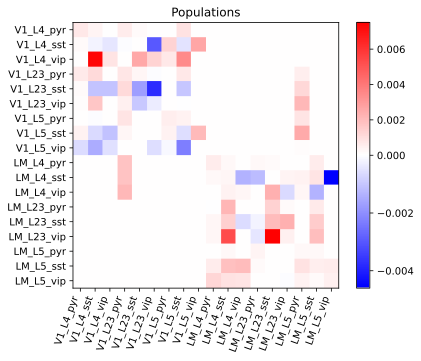

In [ ]:
plt.imshow(diff_pop, cmap='bwr', norm=TwoSlopeNorm(vmin=np.min(diff_pop), vcenter=0))
plt.title("Populations")
plt.colorbar()
plt.xticks(np.arange(len(label_arr_pop)), label_arr_pop, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr_pop)), label_arr_pop)
plt.show()

In [ ]:
# let's swap the order for layers to make it L23, L4, L5
diff_layers_re = diff_layers.copy()

# Swap first and second rows/columns
diff_layers_re[[0, 1]] = diff_layers_re[[1, 0]]  # Swap rows
diff_layers_re[:, [0, 1]] = diff_layers_re[:, [1, 0]]  # Swap columns

# Swap fourth and fifth rows/columns
diff_layers_re[[3, 4]] = diff_layers_re[[4, 3]]  # Swap rows
diff_layers_re[:, [3, 4]] = diff_layers_re[:, [4, 3]]  # Swap columns

model_layers_prob_mean_re = model_layers_prob_mean.copy()
model_layers_prob_mean_re[[0, 1]] = model_layers_prob_mean_re[[1, 0]]  # Swap rows
model_layers_prob_mean_re[:, [0, 1]] = model_layers_prob_mean_re[:, [1, 0]] # Swap columns

model_layers_prob_mean_re[[3, 4]] = model_layers_prob_mean_re[[4, 3]]  # Swap rows
model_layers_prob_mean_re[:, [3, 4]] = model_layers_prob_mean_re[:, [4, 3]]


# Reordering the labels in the same way
label_arr_layers_re = label_arr_layers.copy()
label_arr_layers_re[0], label_arr_layers_re[1] = label_arr_layers_re[1], label_arr_layers_re[0]  # Swap first and second
label_arr_layers_re[3], label_arr_layers_re[4] = label_arr_layers_re[4], label_arr_layers_re[3]

In [ ]:
print(diff_layers_re)
print(np.min(diff_layers_re))

[[ 5.65433921e-04  5.15371189e-04  5.64493646e-05  0.00000000e+00
   0.00000000e+00  5.56022907e-04]
 [ 3.74471932e-04  5.42198541e-04  3.03676515e-04  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.38259419e-04 -3.79385310e-05  3.92154395e-04  0.00000000e+00
   0.00000000e+00  7.98535720e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.54357187e-04
   3.31646856e-04  1.10783835e-04]
 [ 1.39155351e-03  0.00000000e+00  0.00000000e+00  5.38063236e-05
   4.05959971e-04  7.51044718e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.33928487e-04
   2.05991650e-04  2.80287443e-04]]
-3.793853102251887e-05


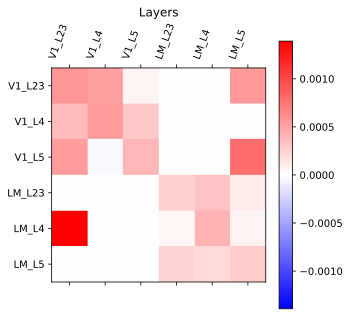

In [ ]:
#plt.imshow(diff_layers_re, cmap='bwr', norm=TwoSlopeNorm(vcenter=0))

plt.matshow(diff_layers_re, cmap='bwr',  vmin=-np.max(abs(diff_layers_re)), vmax=np.max(abs(diff_layers_re)))
plt.title("Layers")
plt.colorbar()
plt.xticks(np.arange(len(label_arr_layers_re)), label_arr_layers_re, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr_layers_re)), label_arr_layers_re)

plt.savefig('/content/drive/My Drive/Aish_celltypeRNN/celltype-comparisons/Thursday_Morning_With_A_Bagel/' + suffix1[:-8] +'vs' + suffix2[:-8] + '.svg', format='svg')
plt.show()


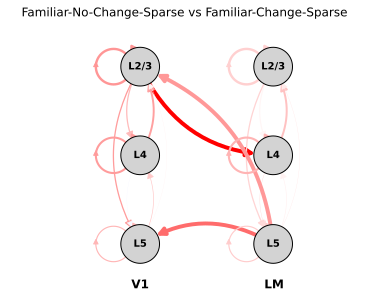

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.colors as mcolors

color_matrix = diff_layers_re.T
width_matrix = model_layers_prob_mean_re.T

# Create a sample 6x6 connection matrix
#pos_color = 'salmon'
#neg_color = 'lightblue'
w_scale = 4
norm = mcolors.Normalize(vmin=-abs(color_matrix).max(), vmax=abs(color_matrix).max())
#cmap = plt.cm.RdBu
cmap = plt.cm.bwr



# Create a directed graph
G = nx.DiGraph()

# Add nodes
for i in range(1, 7):
    G.add_node(i)

edge_colors = []
# Add edges based on connection matrix
for i in range(6):
    for j in range(6):
        prob = width_matrix[i, j] # thickness by prob
        weight = color_matrix[i, j] # color by value
        if weight != 0:  # only add edges with non-zero weights
            G.add_edge(i+1, j+1, weight=prob)
            edge_colors.append(cmap(norm(weight)))

# Manually set the positions of the nodes
pos = {
    1: (0, 1),  # Node 1 at (0,1)
    2: (0, 0),  # Node 2 at (0,0)
    3: (0, -1), # Node 3 at (0,-1)
    4: (1.5, 1),  # Node 4 at (1,1)
    5: (1.5, 0),  # Node 5 at (1,0)
    6: (1.5, -1)  # Node 6 at (1,-1)
}

custom_labels = {1: 'L2/3', 2: 'L4', 3: 'L5', 4: 'L2/3', 5: 'L4', 6: 'L5'}

fig, ax = plt.subplots()
ax.set_xlim(-1.5, 2.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')  # Set the aspect ratio to be equal

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=1500, edgecolors='black', label=None)

# Draw non-self-loop edges
non_self_loops = [(u, v) for u, v in G.edges() if u != v]
positive_edges = [(i, j) for i, j in G.edges() if G[i][j]['weight'] > 0]
negative_edges = [(i, j) for i, j in G.edges() if G[i][j]['weight'] < 0]

edge_widths_positive = [G[u][v]['weight']*w_scale/np.max(abs(width_matrix)) for u, v in positive_edges] # Scale weight for visualization
edge_widths_negative = [G[u][v]['weight']*w_scale/np.max(abs(width_matrix)) for u, v in negative_edges] # Scale weight for visualization
#edge_widths_positive = [w_scale for u, v in positive_edges] # Scale weight for visualization
#edge_widths_negative = [w_scale for u, v in negative_edges] # Scale weight for visualization

nx.draw_networkx_edges(G, pos, edgelist=positive_edges, width=edge_widths_positive,edge_color=edge_colors,
                       arrows=True, arrowstyle='-|>', connectionstyle='arc3,rad=0.3',
                       arrowsize=[ 15 for x in edge_widths_positive], min_target_margin=18)

nx.draw_networkx_edges(G, pos, edgelist=negative_edges, width=edge_widths_negative,edge_color=edge_colors,
                       arrows=True, arrowstyle='-|>', connectionstyle='arc3,rad=0.3',
                       arrowsize=[ 15 for x in edge_widths_negative], min_target_margin=18)

# Draw self-loops with a custom circular style
self_loops = [(u, v) for u, v in G.edges() if u == v]
edge_widths_loop = [G[u][v]['weight']*w_scale/np.max(abs(width_matrix)) for u, v in self_loops]

for u, v in self_loops:
    connect_prob = G[u][v]['weight']*w_scale/np.max(abs(width_matrix))
    color_loop = cmap(norm(color_matrix[u-1, v-1]))

    if weight >= 0:
        loop = plt.Circle((pos[u][0]-0.3, pos[u][1]), 0.2, color=color_loop, fill=False, linewidth=connect_prob)
        plt.arrow(pos[u][0]-0.5, pos[u][1], 0, 0.05, head_width=0.05, head_length=0.05, fc=color_loop, ec=color_loop, length_includes_head=True)# Draw circle for self-loops
    else:
        loop = plt.Circle((pos[u][0]-0.3, pos[u][1]), 0.2, color=color_loop, fill=False, linewidth=connect_prob)
        plt.arrow(pos[u][0]-0.5, pos[u][1], 0, 0.05, head_width=0.05, head_length=0.05, fc=color_loop, ec=color_loop, length_includes_head=True)# Draw circle for self-loops
    ax.add_artist(loop)

#plt.arrow(start_point[0], start_point[1], dx, dy, head_width=0.15, head_length=0.15, fc='blue', ec='blue', length_includes_head=True)
# Labels and title
nx.draw_networkx_labels(G, pos, labels=custom_labels, font_size=10, font_color='black', font_family='sans-serif', font_weight='bold')
plt.text(1.4, -1.5, "LM",  fontsize=12, fontweight='bold')
plt.text(-0.1, -1.5, "V1",  fontsize=12, fontweight='bold')
plt.title(suffix1[:-8]  + ' vs ' +suffix2[:-8])
plt.axis('off')  # Turn off the axis


plt.savefig('/content/drive/My Drive/Aish_celltypeRNN/celltype-comparisons/Thursday_Morning_With_A_Bagel/network_' + suffix1[:-8] +'vs' + suffix2[:-8] + '.svg', format='svg')
plt.show()

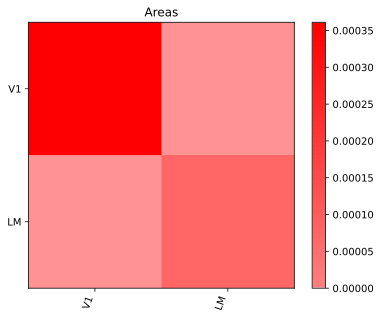

In [ ]:
plt.imshow(diff_areas, cmap='bwr', norm=TwoSlopeNorm(vcenter=0))
plt.title("Areas")
plt.colorbar()
plt.xticks(np.arange(len(label_arr_areas)), label_arr_areas, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr_areas)), label_arr_areas)
plt.show()

#### Sankey diagrams

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
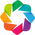

In [ ]:
hv.extension('bokeh')

In [ ]:
def create_sankey(matrix, labels):
    # Ensure the input is a square matrix
    assert matrix.shape[0] == matrix.shape[1], "The input matrix must be square"
    assert matrix.shape[0] == len(labels), "The number of labels must match the dimensions of the matrix"

    sources, targets, values = [], [], []

    # Populate sources, targets, and values based on the matrix
    for ii in range(matrix.shape[0]):
        for jj in range(matrix.shape[1]):
            sources.append(labels[jj]+'_source')
            targets.append(labels[ii]+'_target')
            values.append(matrix[ii,jj])

    # Create a DataFrame
    data = pd.DataFrame({
        'source': sources,
        'target': targets,
        'value': values
    })

    # Create the Sankey diagram
    sankey = hv.Sankey(data)

    # Customize options
    sankey.opts(opts.Sankey(width=600, height=400, cmap='Category20', edge_color=hv.dim('source').str()))

    return sankey

In [ ]:
sankey_pop = create_sankey(diff_pop, label_arr_pop)
sankey_pop

:Sankey   [source,target]   (value)

In [ ]:
sankey_layers = create_sankey(diff_layers, label_arr_layers)
sankey_layers

:Sankey   [source,target]   (value)

In [ ]:
# sankey_areas = create_sankey(diff_areas, label_arr_areas)
# sankey_areas

#### Scatter plot heatmap

In [ ]:
def create_scatter_heat(matrix, labels, av_mask):
    # Ensure the input is a square matrix
    assert matrix.shape[0] == matrix.shape[1], "The input matrix must be square"
    assert matrix.shape[0] == len(labels), "The number of labels must match the dimensions of the matrix"
    assert matrix.shape == av_mask.shape, "The input matrix and connection probabilities  must be of same size"

    sources, targets, values, probs = [], [], [], []

    # Populate sources, targets, and values based on the matrix
    for ii in range(matrix.shape[0]):
        for jj in range(matrix.shape[1]):
            sources.append(labels[jj]+'_source')
            targets.append(labels[ii]+'_target')
            values.append(matrix[ii,jj])
            probs.append(av_mask[ii,jj])

    # Create a DataFrame
    data = pd.DataFrame({
        'source': sources,
        'target': targets,
        'value': values,
        'confidence': probs
    })

    # Customize color bar to ensure it is centered around 0
    norm = TwoSlopeNorm(vmin=data['value'].min(), vcenter=0, vmax=data['value'].max())

    # Apply normalization to the hue data
    data['value_normalized'] = norm(data['value'])

    # Create the scatterplot heatmap diagram
    # Draw each cell as a scatter point with varying size and color
    g = sns.relplot(
        data=data,
        x="source", y="target", hue="value_normalized", size="confidence",
        palette="vlag", edgecolor=".7")

    # Tweak the figure to finalize
    g.set(xlabel="", ylabel="", aspect="equal")
    g.despine(left=True, bottom=True)
    g.ax.margins(.02)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)

    return g

In [ ]:
def calculate_dispersion_and_significance(data, dispersion_type):
    """
    Calculate dispersion for each element across multiple runs and their significance.

    Parameters:
    - data: numpy array of shape (nRuns, val1, val2)
    - dispersion_type: str, one of ['std', 'var', 'range', 'iqr', 'cv']

    Returns:
    - dispersion: numpy array of shape (val1, val2)
    - significance: numpy array of p-values with shape (val1, val2)
    """

    # Check if input data is a numpy array
    if not isinstance(data, np.ndarray):
        raise ValueError("Data should be a numpy array")

    # Check if the dispersion_type is valid
    valid_types = ['std', 'var', 'range', 'iqr', 'cv']
    if dispersion_type not in valid_types:
        raise ValueError(f"Dispersion type should be one of {valid_types}")

    # Initialize the output arrays
    val1, val2 = data.shape[1], data.shape[2]
    dispersion = np.zeros((val1, val2))
    significance = np.zeros((val1, val2))

    for ii in range(val1):
        for jj in range(val2):
            values = data[:, ii, jj]
            if dispersion_type == 'std':
                dispersion[ii, jj] = np.std(values)
            elif dispersion_type == 'var':
                dispersion[ii, jj] = np.var(values)
            elif dispersion_type == 'range':
                dispersion[ii, jj] = np.ptp(values)
            elif dispersion_type == 'iqr':
                dispersion[ii, jj] = np.percentile(values, 75) - np.percentile(values, 25)
            elif dispersion_type == 'cv':
                dispersion[ii, jj] = 1-np.std(values) / np.mean(values)

            # Perform t-test for significance
            t_stat, p_value = ttest_ind(values, values)
            significance[ii, jj] = p_value

    return dispersion, significance

In [ ]:
dispersion_type = 'cv'
disp_pop, sig_pop = calculate_dispersion_and_significance(diff_pop_all, dispersion_type)
disp_layers, sig_layers = calculate_dispersion_and_significance(diff_layers_all, dispersion_type)
disp_areas, sig_areas = calculate_dispersion_and_significance(diff_areas_all, dispersion_type)

<ipython-input-55-df5608b08539>:40: RuntimeWarning: invalid value encountered in scalar divide
  dispersion[ii, jj] = 1-np.std(values) / np.mean(values)


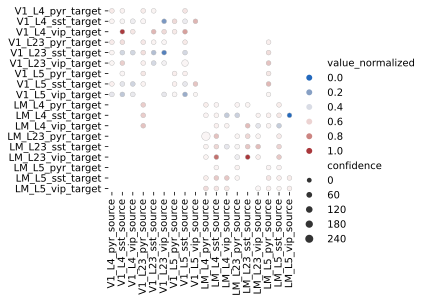

In [ ]:
g_pop = create_scatter_heat(diff_pop, label_arr_pop, disp_pop)

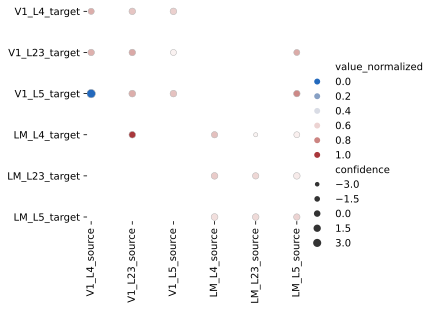

In [ ]:
g_layers = create_scatter_heat(diff_layers, label_arr_layers, disp_layers)

In [ ]:
g_areas = create_scatter_heat(diff_areas, label_arr_areas, disp_areas)

ValueError: vmin, vcenter, and vmax must be in ascending order